In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import json
import os
from scipy.interpolate import griddata
from tqdm import tqdm
from cmb_sim import *
plt.rcParams.update({
    "text.usetex": True,
    "font.family": "sans-serif",
    "font.sans-serif": ["Helvetica"]})
plt.rcParams.update({
    "text.usetex": True,
    "font.family": "serif",
    "font.serif": ["Palatino"],
})

In [11]:
here = os.getcwd()
data_name = 'Logarithmic'
src_dir = os.path.join(here, data_name + ' Data')
srcs = [os.path.join(src_dir, name) for name in os.listdir(src_dir)]

In [12]:
def imp(i):
    s = None
    with open(srcs[i]) as f:
        s = json.load(f)
    return Universe(
        mpG=False,
        mpE=False,
        mpEvolve=True,
        mpInteract=False,
        mpMeasure=False,
        import_set=s)
us = [imp(s) for s in range(len(srcs))]

In [13]:
def redshift(particle, last_universe, time_step):
    """
    Returns z + 1

    Parameters
    ----------
    particle : Particle
        The particle in question.
    last_universe : Universe
        Universe of the previous time step.
    time_step : float
        Length of time step.

    Returns
    -------
    float
        z + 1
    """
    # size = particle.universe.size
    v0 = particle.v
    a = particle.universe.size
    a_old = last_universe.size
    x = particle.x - np.ones((3)) * a / 2
    v = (a - a_old) * x / time_step + a * v0
    [vx, vy, vz] = list(v)
    # print(v)
    vtheta = np.arctan(np.sqrt(vx ** 2 + vy ** 2) / vz)
    vphi = np.arctan(vy / vx)
    rhat = np.array([np.sin(vtheta) * np.cos(vtheta),
                     np.sin(vtheta) * np.sin(vtheta),
                     np.cos(vtheta)])
    # thetahat = np.array([np.cos(vtheta) * np.cos(vtheta),
    #                      np.cos(vtheta) * np.sin(vtheta),
    #                      -np.sin(vtheta)])
    # phihat = np.array([0, -np.sin(vphi), np.cos(vphi)])
    v_rad = np.dot(v, rhat)
    # print(vtheta)
    # print(vphi)
    v_trn = np.sqrt(np.sqrt(np.sum(v ** 2)) - v_rad ** 2)
    # print(v_trn)
    z_rad = np.sqrt((1 + v_rad / 1) / (1 - v_rad / 1)) - 1
    z_trn = 1 / np.sqrt(1 - v_trn ** 2 / 1) - 1
    return np.sqrt(z_rad ** 2 + z_trn ** 2) + 1

def wavelength(redshift, units=True):
    """
    Return the wavelength of the photon given its redshift.

    Parameters
    ----------
    redshift : float
        z + 1
    units : bool, optional
        Whether to include real units, by default True.

    Returns
    -------
    float
        The wavelength in nanometers.
    """
    emit_energy = 13.6
    wl = (1 + redshift) * 2 * np.pi / emit_energy
    if units:
        return 197.3 * wl
    
def scale_wavelengths(arr):
    min_wl = min(arr)
    max_wl = max(arr)
    base_wl = (arr - min_wl) / (max_wl - min_wl)
    new_wl = 380 + base_wl * (750 - 380)
    return new_wl

In [14]:

def wav_to_RGB(wavelength):
    w = int(wavelength)

    # colour
    if w >= 380 and w < 440:
        R = -(w - 440.) / (440. - 350.)
        G = 0.0
        B = 1.0
    elif w >= 440 and w < 490:
        R = 0.0
        G = (w - 440.) / (490. - 440.)
        B = 1.0
    elif w >= 490 and w < 510:
        R = 0.0
        G = 1.0
        B = -(w - 510.) / (510. - 490.)
    elif w >= 510 and w < 580:
        R = (w - 510.) / (580. - 510.)
        G = 1.0
        B = 0.0
    elif w >= 580 and w < 645:
        R = 1.0
        G = -(w - 645.) / (645. - 580.)
        B = 0.0
    elif w >= 645 and w <= 780:
        R = 1.0
        G = 0.0
        B = 0.0
    else:
        R = 0.0
        G = 0.0
        B = 0.0

    # intensity correction
    if w >= 380 and w < 420:
        SSS = 0.3 + 0.7*(w - 350) / (420 - 350)
    elif w >= 420 and w <= 700:
        SSS = 1.0
    elif w > 700 and w <= 780:
        SSS = 0.3 + 0.7*(780 - w) / (780 - 700)
    else:
        SSS = 0.0
    SSS *= 255

    return np.array([int(SSS*R), int(SSS*G), int(SSS*B)]) / 255

def rgb_to_hex(rgb):
    return '%02x%02x%02x' % rgb
rgb_to_hex((255, 255, 195))

'ffffc3'

In [15]:
pre = us[0]
thomson_count = []
ionization_count = []
recombination_count = []
for j in tqdm(range(len(us[1:]))):
    thomson_count.append(0)
    ionization_count.append(0)
    recombination_count.append(0)
    u = us[j + 1]
    for i in range(len(u.particles)):
        p0 = pre.particles[i]
        p1 = u.particles[i]
        if (p1.last_interaction != p0.last_interaction) and (p1.last_interaction is not None):
            if 'Thomson' in p1.last_interaction:
                thomson_count[j] += 1
            elif 'Ionization' in p1.last_interaction:
                ionization_count[j] += 1
            elif 'Recombination' in p1.last_interaction:
                recombination_count[j] += 1
    pre = u
thomson_count = np.array(thomson_count)
ionization_count = np.array(ionization_count)
recombination_count = np.array(recombination_count)

100%|██████████| 299/299 [00:00<00:00, 2686.95it/s]


In [52]:
final_u = us[-11]
pre_final_u = us[-12]
time_step = 0.001
zs = []
for p in final_u.particles:
    if p.type == 'photon':
        zs.append(redshift(p, pre_final_u, time_step))

In [53]:
wl = [wavelength(z) for z in zs]

In [59]:
sizes = np.array([u.size for u in us])

 16%|█▌        | 48/299 [00:16<01:25,  2.93it/s]


KeyboardInterrupt: 

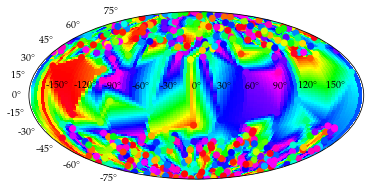

In [18]:
fig = plt.figure()
ax = fig.add_subplot(projection='mollweide')
for i in tqdm(range(len(us) - 1)):
    ax.cla()
    final_u = us[i]
    pre_final_u = us[i + 1]
    time_step = 0.001
    zs = []
    for p in final_u.particles:
        if p.type == 'photon':
            zs.append(redshift(p, pre_final_u, time_step))
    wl = [wavelength(z) for z in zs]
    cmb = get_cmb(final_u)
    x, y, z = cmb
    theta = np.arctan(np.sqrt(x ** 2 + y ** 2) / z)
    phi = np.arctan(y / x)
    lon = np.linspace(-np.pi, np.pi,100)
    lat = np.linspace(-np.pi/2., np.pi/2, 100)
    Lon, Lat = np.meshgrid(lon, lat)
    interp = griddata((2 * phi, theta), wl, (Lon, Lat), method='linear')
    ax.pcolormesh(lon, lat, interp, cmap=plt.cm.gist_rainbow)
    ax.scatter(2 * phi, theta, c=wl, cmap=plt.cm.gist_rainbow)
    os.makedirs(os.path.join(here, data_name + ' Maps'), exist_ok=True)
    out_id = (len(str(len(us))) - len(str(i + 1))) * '0' + str(i + 1)
    plt.savefig(os.path.join(here, data_name + ' Maps', out_id + '.png'), dpi=300)